# Wrangle and Analyze Data

## Project Details

The tasks in this project are as follows:

* Data wrangling, which consists of:
    * Gathering data
    * Assessing data
    * Cleaning data
* Storing, analyzing, and visualizing your wrangled data
* Reporting on 1) your data wrangling efforts and 2) your data analyses and visualizations

## Table of Contents

1. [Gathering Data](#1.-Gathering-Data)
    * [1a. Twitter archive file](#1a.-Twitter-archive-file)
    * [1b. Tweet image predictions](#1b.-Tweet-image-predictions)
    * [1c. Twitter API](#1c.-Twitter-API)
2. [Assessing Data](#2.-Assessing-Data)
    * [2a. Assessing twitter archive](#2a.-Assessing-twitter-archive)
    * [2b. Assessing tweet image predictions](#2b.-Assessing-tweet-image-predictions)
    * [2c. Assessing twitter API data](#2c.-Assessing-twitter-API-data)
    * [Quality issues](#Quality-issues)
    * [Tidiness issues](#Tidiness-issues)
3. [Cleaning Data](#3.-Cleaning-Data)
    * [3a. Cleaning Tidiness issues](#3a.-Cleaning-Tidiness-issues)
    * [3b. Cleaning Quality issues](#3b.-Cleaning-Quality-issues)
4. [Visualization](#4.-Visualization)

## 1. Gathering Data

Gather each of the three pieces of data as described below:

1. The WeRateDogs Twitter archive: `twitter_archive_enhanced.csv`

2. The tweet image predictions (`image_predictions.tsv`) i.e., what breed of dog (or other object, animal, etc.) is present in each tweet according to a neural network.

3. Each tweet's retweet count and favorite ("like") count at minimum, and any additional data you find interesting. Using the tweet IDs in the WeRateDogs Twitter archive, query the Twitter API for each tweet's JSON data using Python's Tweepy library and store each tweet's entire set of JSON data in a file called tweet_json.txt file. Each tweet's JSON data should be written to its own line. Then read this .txt file line by line into a pandas DataFrame with (at minimum) tweet ID, retweet count, and favorite count. Note: do not include your Twitter API keys, secrets, and tokens in your project submission.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import tweepy 
import json
import re
from datetime import datetime
from functools import reduce
from IPython.display import Image
plt.style.use('seaborn')

%matplotlib inline

### 1a. Twitter archive file

In [2]:
archive = pd.read_csv('twitter-archive-enhanced-2.csv')
archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


### 1b. Tweet image predictions

In [3]:
images = pd.read_csv('image-predictions-3.tsv', sep = '\t')
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


### 1c. Twitter API

In [7]:
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, parser=tweepy.parsers.JSONParser())

In [8]:
# use Twitter API to collect status data on tweets present in archive
tweet_data = []
tweet_id_success = []
tweet_id_missing = []
for tweet_id in archive['tweet_id']:
    try:
        data = api.get_status(tweet_id, 
                              tweet_mode='extended',
                              wait_on_rate_limit = True,
                              wait_on_rate_limit_notify = True)
        tweet_data.append(data)
        tweet_id_success.append(tweet_id)
    except Exception as e:
        tweet_id_missing.append(tweet_id)
        print(f'{tweet_id}: {e}')

889638837579907072: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=889638837579907072&tweet_mode=extended (Caused by SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')")))
888804989199671297: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=888804989199671297&tweet_mode=extended (Caused by SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')")))
888202515573088257: Failed to send request: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))
887705289381826560: Failed to send request: HTTPSConnectionPool(host='api.twitter.com', port=443): Max retries exceeded with url: /1.1/statuses/show.json?id=887705289381826560&tweet_mode=extended (Caused by SSLError(SSLError("bad handshake: SysCallError(104, 'ECONNRESET')")))
887517139158093824: Failed to se

In [9]:
# Write tweet data to json file
with open('tweet_json.txt', mode = 'w') as file:
    json.dump(tweet_data, file)

In [4]:
# Load the Twitter API data
api_data = pd.read_json('tweet_json.txt')
api_data['tweet_id'] = api_data['id']
api_data = api_data[['tweet_id', 'favorite_count', 'retweet_count']]

In [5]:
api_data.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36237,7715
1,892177421306343426,31259,5701
2,891815181378084864,23534,3780
3,891689557279858688,39539,7876
4,891327558926688256,37758,8486


## 2. Assessing Data

After gathering each of the above pieces of data, assess them visually and programmatically for quality and tidiness issues. Detect and document at least eight (8) quality issues and two (2) tidiness issues.

### 2a. Assessing twitter archive

In [3]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

`tweet_id` is an integer.  
`timestamp` and `retweeted_status_timestamp` are of 'object' datatype.

In [4]:
# duplicates
sum(archive['tweet_id'].duplicated())

0

---
**name**

In [59]:
# name having length less than 3 or 'None'
archive[archive['name'].apply(lambda x: str(x)=='None' or len(str(x)) < 3)]['name']

5       None
7       None
12      None
24      None
25      None
        ... 
2351    None
2352       a
2353       a
2354       a
2355    None
Name: name, Length: 824, dtype: object

`name` has values that are string 'None' instead of NaN and some values have unusual names of less than 3 characters such as 'a'.

---
**ratings**

In [35]:
print(archive['rating_denominator'].describe())
print('-'*40)
print(archive['rating_denominator'].value_counts())

count    2356.000000
mean       10.455433
std         6.745237
min         0.000000
25%        10.000000
50%        10.000000
75%        10.000000
max       170.000000
Name: rating_denominator, dtype: float64
----------------------------------------
10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64


In [105]:
# printing first tweet of every possible value of 'rating_denominator'
denominator = archive['rating_denominator'].value_counts()
for c, i in enumerate(denominator.index):
    print(f"{c}: {archive.loc[archive['rating_denominator'] == i, 'text'].values[0]}")

0: This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
1: RT @dog_rates: After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https:/…
2: This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq
3: Here's a brigade of puppers. All look very prepared for whatever happens next. 80/80 https://t.co/0eb7R1Om12
4: Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a
5: This is an Albanian 3 1/2 legged  Episcopalian. Loves well-polished hardwood flooring. Penis on the collar. 9/10 https://t.co/d9NcXFKwLv
6: I'm aware that I could've said 20/16, but here at WeRateDogs we are very professional. An inconsistent rating scale is simply irresponsible
7: Happy Wednesday here's a bucket of pups. 44/40 would pet all at once https://t.co/HppvrYuamZ
8: The floofs have been released I repeat the floofs have been 

Some of the ratings are wrongly mentioned e.g. in the last one (17th), the rating should be 13/10, not 960/00.  
Some tweets are not about dogs, so doesn't contain rating e.g. 6th and 9th one. (tweets not containing dog images can be discarded).
Tweets starting from RT are retweets.

In [36]:
print(archive['rating_numerator'].describe())
print('-'*40)
print(archive['rating_numerator'].value_counts())

count    2356.000000
mean       13.126486
std        45.876648
min         0.000000
25%        10.000000
50%        11.000000
75%        12.000000
max      1776.000000
Name: rating_numerator, dtype: float64
----------------------------------------
12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64


In [107]:
# printing first tweet of every possible value of 'rating_numerator'
numerator = archive['rating_numerator'].value_counts()
for c, i in enumerate(numerator.index):
    print(f"{c}: {archive.loc[archive['rating_numerator'] == i, 'text'].values[0]}")

0: This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB
1: Please don't send in photos without dogs in them. We're not @porch_rates. Insubordinate and churlish. Pretty good porch tho 11/10 https://t.co/HauE8M3Bu4
2: @ComplicitOwl @ShopWeRateDogs &gt;10/10 is reserved for dogs
3: This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU
4: RT @dog_rates: Meet Beau &amp; Wilbur. Wilbur stole Beau's bed from him. Wilbur now has so much room for activities. 9/10 for both pups https:/…
5: RT @dog_rates: Here we see a rare pouched pupper. Ample storage space. Looks alert. Jumps at random. Kicked open that door. 8/10 https://t.…
6: I was going to do 007/10, but the joke wasn't worth the &lt;10 rating
7: This is Cassie. She is a college pup. Studying international doggo communication and stick theory. 14/10 so elegant much sophisticate https://t.co/t1

Some of the ratings contain decimal e.g. 8th one.  
Some tweets doesn't contain dog pictures e.g. 16th, 19th, 31st.

---
**retweets**

In [64]:
# consider only orignal tweets (no retweets) 
archive[archive['retweeted_status_id'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


---
### 2b. Assessing tweet image predictions

In [117]:
images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [110]:
images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [113]:
# missing rows
len(archive) - len(images)

281

In [115]:
# duplicates
sum(images['jpg_url'].duplicated())

66

---
### 2c. Assessing twitter API data

In [13]:
api_data.head()

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36237,7715
1,892177421306343426,31259,5701
2,891815181378084864,23534,3780
3,891689557279858688,39539,7876
4,891327558926688256,37758,8486


In [12]:
api_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2325 entries, 0 to 2324
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2325 non-null   int64
 1   favorite_count  2325 non-null   int64
 2   retweet_count   2325 non-null   int64
dtypes: int64(3)
memory usage: 54.6 KB


In [14]:
# missing rows
len(archive) - len(api_data)

31

In [15]:
# duplicates
sum(api_data['tweet_id'].duplicated())

0

---
### Quality issues

**Twitter archive file**

* archive data contains retweets.
* `tweet_id` is an integer
* `timestamp` is of 'object' datatype.
* name has values that are string 'None' instead of `NaN` and some values have unusual names of less than 3 characters such as 'a'.
* Some of the ratings are wrongly mentioned e.g. in one case, the rating should've been 13/10, not 960/00, while some tweets are not about dogs, so doesn't contain rating (tweets not containing dog images can be discarded), and some of the ratings contain decimal in the numerator.
* `NaN`s represented as 'None' (str) for name, doggo, floofer, pupper, and puppo columns.

**Tweet image predictions**

* There are some missing rows in images dataset (2075 rows instead of 2356): either the rows are missing or some tweets didn't have dog images.
* There are some duplicate `jpg_url`s.
* `p1`, `p2`, and `p3` contains underscores instead of spaces in the string.

**Twitter API data**

* There are some missing tweets compared to the data of archive.

### Tidiness issues

* There are 4 different columns (doggo, floofer, pupper, and puppo) for dog stages.
* The different dataframes should be merged into a single one.

---
## 3. Cleaning Data

Clean each of the issues you documented while assessing. The result should be a high quality and tidy master pandas DataFrame (or DataFrames, if appropriate). Again, the issues that satisfy the Project Motivation must be cleaned.
Storing, Analyzing, and Visualizing Data for this Project

Store the clean DataFrame(s) in a CSV file with the main one named `twitter_archive_master.csv`. If additional files exist because multiple tables are required for tidiness, name these files appropriately. Additionally, you may store the cleaned data in a SQLite database (which is to be submitted as well if you do).

In [6]:
# create copies of the dataframes for cleaning
archive_clean = archive.copy()
images_clean = images.copy()
api_clean = api_data.copy()

---
### 3a. Cleaning Tidiness issues

#### Define 
**Tidiness issue #1:** Merge all dataframes
#### Code

In [7]:
# merge the dataframes
dfs = [archive_clean, images_clean, api_clean]
twitter = reduce(lambda left,right: pd.merge(left,right,on='tweet_id'), dfs)
# By merging, we've already removed tweets not containing dog images.

#### Test

In [8]:
twitter.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,36237,7715
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,31259,5701


In [9]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2053 entries, 0 to 2052
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2053 non-null   int64  
 1   in_reply_to_status_id       23 non-null     float64
 2   in_reply_to_user_id         23 non-null     float64
 3   timestamp                   2053 non-null   object 
 4   source                      2053 non-null   object 
 5   text                        2053 non-null   object 
 6   retweeted_status_id         72 non-null     float64
 7   retweeted_status_user_id    72 non-null     float64
 8   retweeted_status_timestamp  72 non-null     object 
 9   expanded_urls               2053 non-null   object 
 10  rating_numerator            2053 non-null   int64  
 11  rating_denominator          2053 non-null   int64  
 12  name                        2053 non-null   object 
 13  doggo                       2053 

#### Define
**Tidiness issue #2:** Single column for dog stages
#### Code

In [10]:
# select the columns to melt and to remain
MELTS_COLUMNS = ['doggo', 'floofer', 'pupper', 'puppo']
STAY_COLUMNS = [x for x in twitter.columns.tolist() if x not in MELTS_COLUMNS]

# melt the the columns into values
twitter = pd.melt(twitter, id_vars = STAY_COLUMNS, value_vars = MELTS_COLUMNS, 
                         var_name = 'stages', value_name = 'dog_stage')
# delete column 'stages'
twitter = twitter.drop('stages', 1)

# sort by dog_stage then drop duplicated based on tweet_id except the last occurrence
twitter = twitter.sort_values('dog_stage').drop_duplicates(subset='tweet_id', keep='last')

# replace 'None' with NaNs
twitter['dog_stage'].replace('None', np.nan, inplace = True)

# change dtype to categorical
twitter['dog_stage'] = twitter['dog_stage'].astype("category")

In [11]:
twitter['dog_stage'].value_counts()

pupper     221
doggo       65
puppo       24
floofer      8
Name: dog_stage, dtype: int64

#### Test

In [12]:
twitter.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'favorite_count', 'retweet_count', 'dog_stage'],
      dtype='object')

---
### 3b. Cleaning Quality issues

#### Define

**Quality issue #1:** Drop duplicated `jpg_url`s

#### Code

In [13]:
# duplicate `jpg_url`
sum(twitter['jpg_url'].duplicated())
# high number is due to melting done above, it'll be fixed by droping duplicates

59

In [14]:
# drop duplicate jpg_url
twitter.drop_duplicates(subset=['jpg_url'], keep='last', inplace=True)

#### Test

In [15]:
sum(twitter['jpg_url'].duplicated())

0

#### Define

**Quality issue #2:** Replace underscore with space in `p1`, `p2`, and `p3`

#### Code

In [16]:
# replace underscores with spaces in p1, p2, and p3
twitter['p1'].replace('_', ' ', regex=True, inplace = True)
twitter['p2'].replace('_', ' ', regex=True, inplace = True)
twitter['p3'].replace('_', ' ', regex=True, inplace = True)

#### Test

In [17]:
twitter['p1']

1976            Rottweiler
1975             porcupine
1974                 goose
1973    Labrador retriever
1972       Tibetan terrier
               ...        
6661    Labrador retriever
7029                  chow
6216     Italian greyhound
6172      golden retriever
6473      Lakeland terrier
Name: p1, Length: 1994, dtype: object

#### Define
**Quality issue #3:** Remove retweets
#### Code

In [18]:
# consider only orignal tweets (no retweets) 
twitter = twitter[twitter['retweeted_status_id'].isnull()]
# remove retweet related columns
twitter = twitter.drop(['retweeted_status_id', 
                        'retweeted_status_user_id', 
                        'retweeted_status_timestamp'], 
                       axis=1)

#### Test

In [19]:
twitter.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'jpg_url', 'img_num', 'p1', 'p1_conf',
       'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog',
       'favorite_count', 'retweet_count', 'dog_stage'],
      dtype='object')

#### Define
**Quality issue #4:** Change dtype of `tweet_id` to `str`
#### Code

In [20]:
# fix 'tweet_id' to str/object
twitter['tweet_id'] = twitter['tweet_id'].astype(str)

#### Test

In [21]:
twitter['tweet_id'].dtype

dtype('O')

#### Define
**Quality issue #5:** Change dtype of `timestamp` to `datetime`
#### Code

In [22]:
# change the 'timestamp' column to a datetime object
twitter['timestamp'] = pd.to_datetime(twitter['timestamp'])

#### Test

In [23]:
twitter['timestamp'].dtype

datetime64[ns, UTC]

#### Define
**Quality issue #6:** Fix various issues with `name`
#### Code

In [24]:
# find names starting with a lowercase letter
lowercase_names = []
for row in twitter['name']:
    if row[0].islower() and row not in lowercase_names:
        lowercase_names.append(row)
print(lowercase_names)

['a', 'an', 'quite', 'the', 'getting', 'actually', 'infuriating', 'very', 'light', 'space', 'just', 'by', 'officially', 'incredibly', 'one', 'my', 'this', 'unacceptable', 'not', 'his', 'all']


In [25]:
# replace names starting with a lowercase letter with NaNs
twitter['name'].replace(lowercase_names, np.nan, inplace = True)

# replace 'None' with NaN
twitter['name'].replace('None', np.nan, inplace = True)

#### Test

In [26]:
# find names starting with a lowercase letter
lowercase_names[0] in twitter['name']

False

#### Define
**Quality issue #7:** Fix various issues with ratings
#### Code

In [27]:
# list tweets where rating is in decimal
decimal = twitter[twitter['text'].str.contains(r"(\d+\.\d*\/\d+)")]
print(decimal[['tweet_id', 'rating_numerator', 'text']].values)

[['883482846933004288' 5
  'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948']
 ['680494726643068929' 26
  'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']
 ['786709082849828864' 75
  "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"]
 ['778027034220126208' 27
  "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"]]


/home/harshit/anaconda3/envs/py14/lib/python3.7/site-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [28]:
ratings_with_decimals_text = []
ratings_with_decimals_index = []
ratings_with_decimals = []

for i, text in twitter['text'].iteritems():
    if bool(re.search('\d+\.\d+\/\d+', text)):
        ratings_with_decimals_text.append(text)
        ratings_with_decimals_index.append(i)
        ratings_with_decimals.append(re.search('\d+\.\d+', text).group())

In [29]:
# replace incorrect rating with correct decimal rating in numerator from text
for i in range(len(ratings_with_decimals)):
    twitter.loc[ratings_with_decimals_index[i],'rating_numerator'] = float(ratings_with_decimals[i])

In [30]:
# add new 'rating' column by dividing rating_numerator by rating_denominator
twitter['rating'] = twitter['rating_numerator'] / twitter['rating_denominator']

#### Test

In [33]:
decimal = twitter[twitter['text'].str.contains(r"(\d+\.\d*\/\d+)")]
print(decimal[['tweet_id', 'rating_numerator', 'text']].values)

[['883482846933004288' 13.5
  'This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948']
 ['680494726643068929' 11.26
  'Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD']
 ['786709082849828864' 9.75
  "This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS"]
 ['778027034220126208' 11.27
  "This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq"]]


In [34]:
twitter['rating']

1976    1.2
1975    1.0
1974    0.6
1973    1.1
1972    0.7
       ... 
6661    1.2
7029    1.1
6216    1.3
6172    1.3
6473    1.3
Name: rating, Length: 1946, dtype: float64

#### Define
**Quality issue #8:** Drop superfluous columns
#### Code

In [35]:
# drop superfluous columns
twitter.drop(['in_reply_to_status_id', 
              'in_reply_to_user_id',
              'source',
              'img_num'], axis=1, inplace=True)

#### Test

In [36]:
twitter.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1946 entries, 1976 to 6473
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            1946 non-null   object             
 1   timestamp           1946 non-null   datetime64[ns, UTC]
 2   text                1946 non-null   object             
 3   expanded_urls       1946 non-null   object             
 4   rating_numerator    1946 non-null   float64            
 5   rating_denominator  1946 non-null   int64              
 6   name                1317 non-null   object             
 7   jpg_url             1946 non-null   object             
 8   p1                  1946 non-null   object             
 9   p1_conf             1946 non-null   float64            
 10  p1_dog              1946 non-null   bool               
 11  p2                  1946 non-null   object             
 12  p2_conf             1946 non-nu

In [268]:
# save twitter dataframe to a CSV file
twitter.to_csv('twitter_archive_master.csv')

---
## 4. Visualization

Analyze and visualize your wrangled data. At least three (3) insights and one (1) visualization must be produced.

In [2]:
twitter = pd.read_csv('twitter_archive_master.csv')

### Favorite Vs Retweet count

/home/harshit/anaconda3/envs/py14/lib/python3.7/site-packages/seaborn/regression.py:574: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


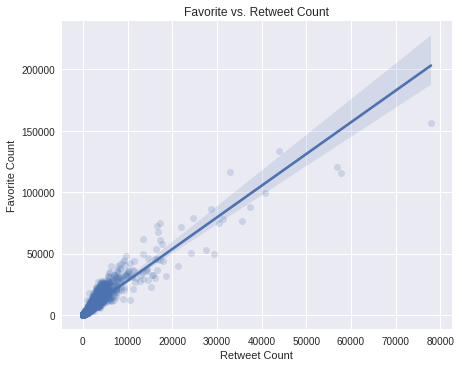

In [212]:
sns.lmplot(x="retweet_count", 
           y="favorite_count", 
           data=twitter,
           size = 5,
           aspect=1.3,
           scatter_kws={'alpha':1/5})
plt.title('Favorite vs. Retweet Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

There is a positive correlations between favorites and retweet counts.

### Rating over time

In [181]:
twitter['rating'].value_counts()

1.200000      441
1.000000      414
1.100000      393
1.300000      244
0.900000      151
0.800000       95
0.700000       51
0.500000       33
1.400000       33
0.600000       32
0.300000       19
0.400000       15
0.200000       10
0.100000        4
0.000000        2
0.975000        1
3.428571        1
0.636364        1
1.127000        1
0.818182        1
1.126000        1
42.000000       1
177.600000      1
1.350000        1
Name: rating, dtype: int64

In [3]:
# remove outliers
twitter = twitter[twitter['rating']<1.5]

Text(0, 0.5, 'Standardized Rating')

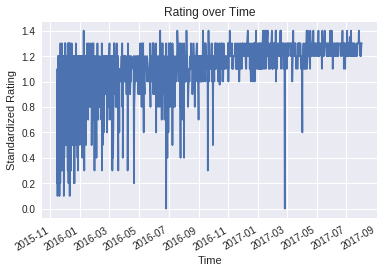

In [213]:
# plot rating over time
rating_history = twitter.groupby('timestamp')['rating'].mean()
rating_history.plot(kind='line')
plt.title('Rating over Time')
plt.xlabel('Time')
plt.ylabel('Standardized Rating')

The above graph shows that the rating have improved over time. There are very few ratings below 1.0 in 2017 compared to 2016.

### Rating Vs Retweet count

Text(0.5, 1.0, 'Rating Vs Retweet Counts')

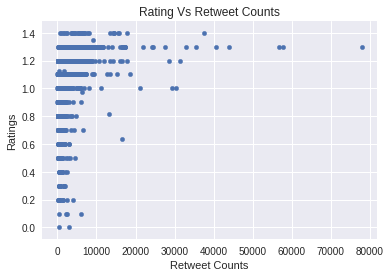

In [214]:
# rating Vs retweet counts
twitter.plot(x='retweet_count', y='rating', kind='scatter')
plt.xlabel('Retweet Counts')
plt.ylabel('Ratings')
plt.title('Rating Vs Retweet Counts')

The trend that higher rating yields more retweets isn't consistent as per the above graph.

### Most common dog stages

Text(0.5, 0.98, 'Dog stages')

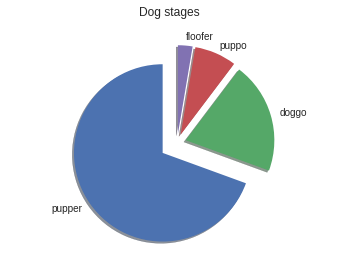

In [209]:
# pie chart of dog stage
dog_stage_count = list(twitter[twitter['dog_stage'] != 'None']['dog_stage'].value_counts())[0:4]
dog_stages = twitter[twitter['dog_stage'] != 'None']['dog_stage'].value_counts().index.tolist()[0:4]
explode = (0.2, 0.1, 0.1, 0.1) 

plt.pie(dog_stage_count, explode = explode, labels = dog_stages, shadow = True, startangle = 90)
plt.axis('equal')
plt.suptitle('Dog stages')

The most common dog stage is pupper.

### Average rating by dog stages

Text(0.5, 0.98, 'Average rating by dog stages')

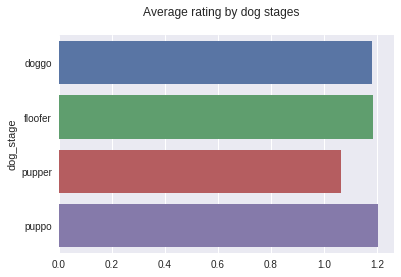

In [12]:
dog_stage_rating = twitter.groupby('dog_stage')['rating'].mean()
sns.barplot(dog_stage_rating.values, dog_stage_rating.index)
plt.suptitle('Average rating by dog stages')

The highest rated dog stage is puppo.

Text(0.5, 0.98, 'Rating variation by dog stages')

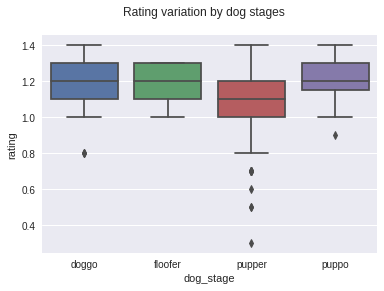

In [21]:
sns.boxplot(data=twitter, y='rating', x='dog_stage')
plt.suptitle('Rating variation by dog stages')

The above graph shows the variation of rating by dog stages.

### Most common dog names

Text(0.5, 0.98, 'Most common dog names')

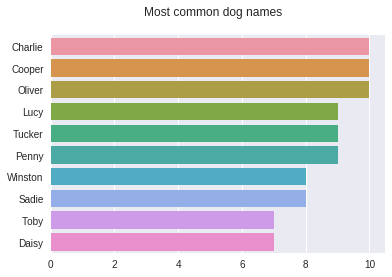

In [211]:
names = twitter['name'].value_counts()[:10]
sns.barplot(names.values, names.index)
plt.suptitle('Most common dog names')

The most common dog names are Charlie, Cooper, and Oliver.

### Most common dog types

Text(0.5, 0.98, 'Most common dog type')

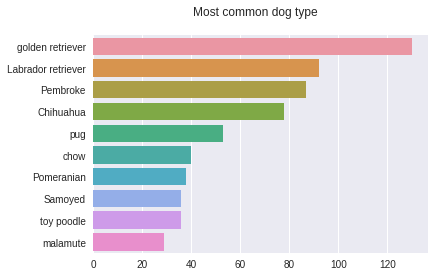

In [11]:
dog_type = twitter['p1'].value_counts()[:10]
sns.barplot(dog_type.values, dog_type.index)
plt.suptitle('Most common dog type')

The most common dog type is golden retriever.

### Sample prediction by image prediction model

In [229]:
# let's look at a dog having rating higher than 1.2 of the most common dog stage 'pupper'
dog = twitter[(twitter['rating'] > 1.2) & (twitter['dog_stage']=='pupper') & (twitter['name']=='Dido')]
dog

,tweet_id,timestamp,text,expanded_urls,rating_numerator,rating_denominator,name,jpg_url,p1,p1_conf,...,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,favorite_count,retweet_count,dog_stage,rating
4457,817777686764523521,2017-01-07 16:59:28+00:00,"This is Dido. She's playing the lead role in ""...",https://twitter.com/dog_rates/status/817777686...,13.0,10,Dido,https://pbs.twimg.com/ext_tw_video_thumb/81777...,curly-coated retriever,0.733256,...,flat-coated retriever,0.214145,True,Irish water spaniel,0.029769,True,10914,2740,pupper,1.3


This is Dido. She's playing the lead role in "Pupper Stops to Catch Snow Before Resuming Shadow Box with Dried Apple." 13/10 (IG: didodoggo) https://t.co/m7isZrOBX7
Is dog?: True, type: curly-coated retriever, confidence: 0.73, rating: 1.3, favorites: 10914, retweets: 2740


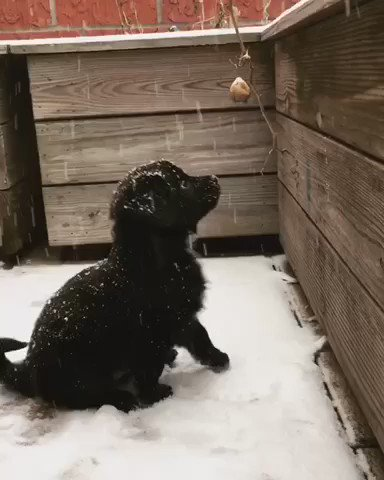

In [267]:
print(dog['text'].values[0])
print(f"Is dog?: {dog['p1_dog'].values[0]}, type: {dog['p1'].values[0]}, confidence: {dog['p1_conf'].values[0]:.2f}, rating: {dog['rating'].values[0]}, favorites: {dog['favorite_count'].values[0]}, retweets: {dog['retweet_count'].values[0]}")
Image(dog['jpg_url'].values[0])

For this dog, the predictions were correct.

---